# Analysis & visualization of results

In [14]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

Below, we read in the results from applying HBAC on random noise data (from a standard normal distribution) and then computing the difference between each cluster and the other clusters.

In [15]:
# need `pyarrow` package to load parquet files
df = pd.read_parquet('./results_clust.parquet.gzip')
df.head()

,iter,cluster_nr,p_clust,diff_clust,size_clust,method,N,K,target_col,bonf_correct
0,0,0,0.456115,-0.378788,6,hbac,50,1,y,True
1,0,1,2.214504,-0.142857,15,hbac,50,1,y,True
2,0,2,4.266701,0.083056,7,hbac,50,1,y,True
3,0,3,4.266701,0.083056,7,hbac,50,1,y,True
4,0,4,2.572252,0.189394,6,hbac,50,1,y,True


In total, the analysis was repeated 500 times ('iterations'):

In [16]:
df['iter'].min(), df['iter'].max()

(0, 499)

To get insight into what factors mitigate or exacerbate the potential 'bias' in the method, I varied a couple of parameters in the experiment, such as the number of observations (`N`):

In [17]:
df['N'].unique()

array([  50,  100,  500, 1000])

... and the number of features (`K`):

In [18]:
df['K'].unique()

array([  1,   5,  10,  50, 100])

And importantly I ran the experiment for different target variables (`target_col`):

In [19]:
df['target_col'].unique()

['y', 'y_pred', 'fp', 'fn', 'err', 'fp_prec', 'fn_rec']
Categories (7, object): ['err', 'fn', 'fn_rec', 'fp', 'fp_prec', 'y', 'y_pred']

In technical terms, using `y_pred` boils down to _demographic parity_, `fp` to _predictive equality_, etc. etc. Importantly, I also added the complement of _precision_ (`fp_prec`) and _recall_ (`fn_rec`), as this doesn't group true positives and false negatives together (as `fp` does).

Also, separate experiments are run with and without bonferroni correction to correct for the testing of multiple clusters (`bonf_correct`). To compare HBAC to truly random clusters, the experiment was also run on data where each observation was assigned one of five random cluster labels (literally just `np.random.choice(range(5), size=N)`):

In [20]:
df['method'].unique()

['hbac', 'randomclusters']
Categories (2, object): ['hbac', 'randomclusters']

Importantly, for each cluster (`cluster_nr`), the difference in the target variable between each cluster and the remaining clusters is computed (`diff_clust`) as well as the corresponding _p_-value (using a two-sample t-test, like in the Misztal-Radecka & Indurkhya paper).

## Analysis

To get an idea of what causes the magnitude in cluster differences, we can run a simple linear model with `diff_clust` as dependent variable:

In [21]:
df_ = df.query("method == 'hbac' & ~bonf_correct").copy()
df_['target_col'] = df_['target_col'].astype(str)
smf.ols('diff_clust ~ target_col + N + K + cluster_nr', data=df_).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             diff_clust   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                 6.567e+04
Date:                Mon, 23 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:31:14   Log-Likelihood:             3.1066e+05
No. Observations:              469410   AIC:                        -6.213e+05
Df Residuals:                  469400   BIC:                        -6.212e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.1404      0.001   -248.040      0.000      -0.142      -0.139
target_col[T.fn]          0.1256      0.001    194.371      0.000       0.124       0.127
target_col[T.fn_rec]      0.0416      0.001     57.629      0.000       0.040       0.043
target_col[T.fp]          0.1256      0.001    194.477      0.000       0.124       0.127
target_col[T.fp_prec]     0.0224      0.001     33.929      0.000       0.021       0.024
target_col[T.y]          -0.0007      0.001     -1.179      0.239      -0.002       0.000
target_col[T.y_pred]      0.0202      0.001     29.966      0.000       0.019       0.022
N                     -9.061e-05   5.06e-07   -179.219      0.000   -9.16e-05   -8.96e-05
K                        -0.0003   4.85e-06    -52.593      0.000      -0.000      -0.000
cluster_nr                0.0491   6.86e-05    714.973      0.000       0.049       0.049
==============================================================================
Omnibus:                    31074.056   Durbin-Watson:                   1.492
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           120462.671
Skew:                           0.236   Prob(JB):                         0.00
Kurtosis:                       5.436   Cond. No.                     4.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Seems like (in total) most of the variance is driven by the type of target variable used (`target_col`). Let's check this out:

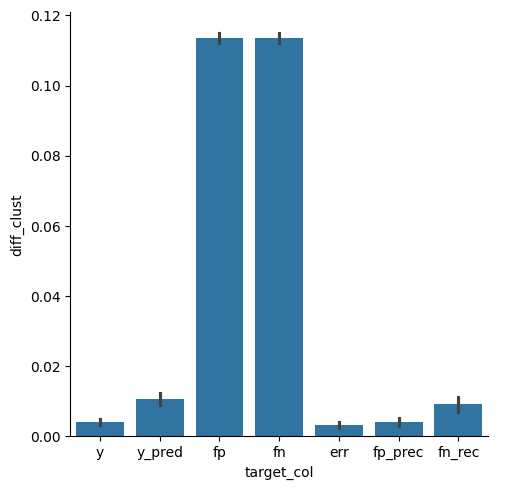

In [22]:
g = sns.catplot(df_, x='target_col', y='diff_clust', kind='bar')

As you can see, when false positives (`fp`) or false negatives (`fn`) are used as target variable, then the *average difference* (across clusters) between a cluster and the rest is larger than 11%! Note that this is averaged across clusters.

The other major factor is 'cluster nr', so the order of the clusters found by the HBAC algorithm. Let's visualize the above plot but separately for each cluster:

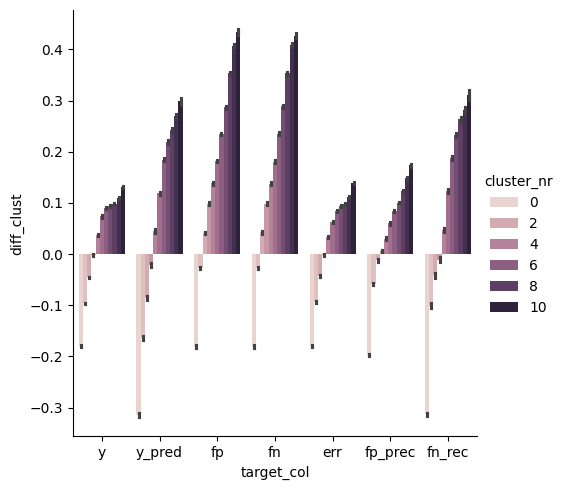

In [23]:
g = sns.catplot(df_, x='target_col', y='diff_clust', hue='cluster_nr', kind='bar')

This is pretty disconcerting: higher clusters display up to about a 40% difference in the target variable relative to the remaining clusters &mdash; in random data! This could, technically, be due to chance (although the error bars, reflecting the 95% CI, suggests otherwise). What we can do is to check the proportion of iterations with at least one significant cluster (at $\alpha = 0.05$). At least, this would be the case for a single test, but because each cluster is tested, the p-values need to be adjusted (by multiplying them with the amount of tests performed per iteration). 

For an unbiased method, we'd expect this proportion (the method's _false positive rate_) to be 0.05, but this is not the case (also not for bonferroni-correct p-values):

/var/folders/45/rtxhngzn5cx3sjdxtnq5bk700000gp/T/ipykernel_78348/3225683359.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_av = df_bonf.groupby(params).mean().reset_index()


Text(43.87154393325616, 0.5, 'False positive rate')

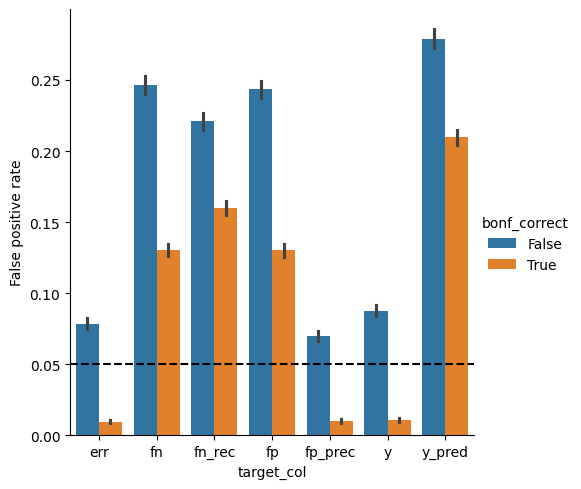

In [24]:
df_bonf = df.query("method == 'hbac'").copy()
df_bonf['sig_clust'] = ((df_bonf['p_clust'] < 0.05) & (df_bonf['diff_clust'] > 0)).astype(int)
params = ['iter', 'N', 'K', 'target_col', 'method', 'bonf_correct']
df_av = df_bonf.groupby(params).mean().reset_index()
df_av['at_least_one'] = (df_av['sig_clust'] > 0).astype(int)
g = sns.catplot(data=df_av, x='target_col', y='at_least_one', hue='bonf_correct', kind='bar')
g.ax.axhline(0.05, ls='--', c='k')
g.ax.set_ylabel("False positive rate")

For several metrics (like `fn`, `fp`, `y_pred`), the FPR is as high as 0.5, meaning that in 50% of the times HBAC is applied to random data, it will find at least one significant cluster. Just for good measure, when clusters are truly randomly generated, the expected FPR is actually approximately 0.05 (after bonferroni correction):

/var/folders/45/rtxhngzn5cx3sjdxtnq5bk700000gp/T/ipykernel_78348/1439770806.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_bonf = df_bonf.groupby(params).mean().reset_index()


Text(43.87154393325616, 0.5, 'False positive rate')

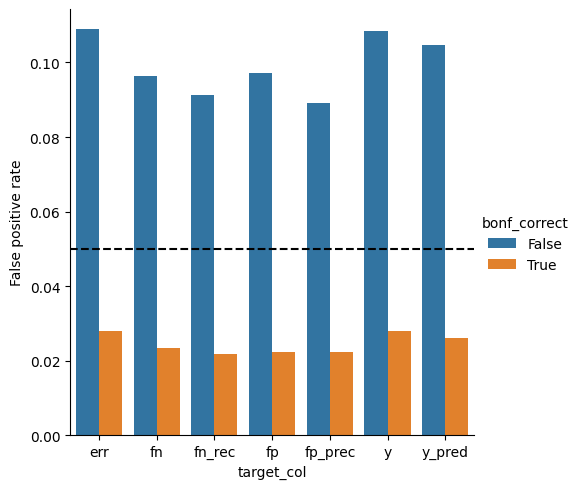

In [25]:
df_bonf = df.query("method == 'randomclusters'").copy()
df_bonf['sig_clust'] = (df_bonf['p_clust'] < 0.05).astype(int)
params = ['iter', 'N', 'K', 'target_col', 'method', 'bonf_correct']
df_bonf = df_bonf.groupby(params).mean().reset_index()
df_bonf['at_least_one'] = (df_bonf['sig_clust'] > 0).astype(int)
g = sns.catplot(data=df_bonf, x='target_col', y='at_least_one', hue='bonf_correct', kind='bar', errorbar=None)
g.ax.axhline(0.05, ls='--', c='k')
g.ax.set_ylabel('False positive rate')

As hinted at before when plotting the average differences per cluster, the largest differences and thus the largest proportion of significant results occur in the 'higher' cluster numbers:

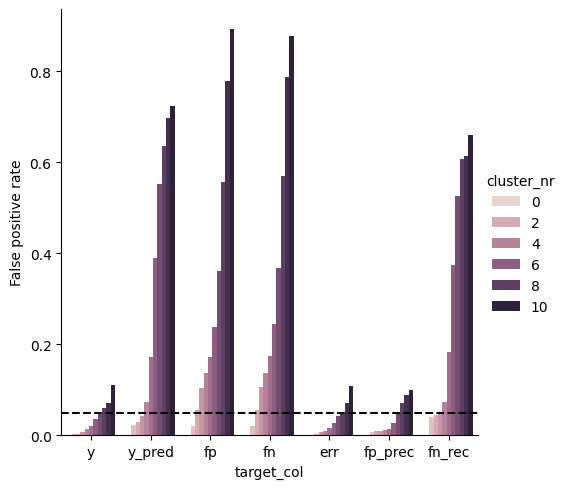

In [26]:
# To be lenient, let's only consider differences > 0 (not < 0)
df_['sig_clust'] = ((df_['p_clust'] < 0.05) & (df_['diff_clust'] > 0)).astype(int)
g = sns.catplot(data=df_, x='target_col', y='sig_clust', hue='cluster_nr', kind='bar', errorbar=None)
g.ax.axhline(0.05, ls='--', c='k')
g.ax.set_ylabel('False positive rate');

This kind of makes sense, as the method only allows to split into new clusters as the new clusters show bigger 'bias' than the original cluster (the line `max(score0, score1) >= score` in HBAC).